<a href="https://colab.research.google.com/github/ParkSomin23/Voice_EmotionDetection/blob/master/CNN_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable

import numpy as np

import os
import sys

import pandas as pd
import pickle

import time


In [2]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from keras.utils import np_utils, to_categorical

In [3]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


**Data**

In [4]:
class myDataset(Dataset):
    def __init__(self, d, l):
      self.d = d
      self.l = l

    def __getitem__(self, idx):
      data = self.d[idx]
      data = np.transpose(data,(2,0,1))
      #data = np.repeat(data, 3, axis=0) #(3, feat, time)
      #data = np.transpose(data, (1, 2, 0))
      l = self.l[idx].argmax()
      #label = emo_dict[l]
      #label = self.l[idx]
      return data, l

## (freq, time, 1D를 duplicate해서 3개로) 지금은 1, feat, time


    def __len__(self):
      return len(self.d)

In [5]:
import pickle
import pandas as pd

with open("/gdrive/My Drive/20.08.16/RAVDESS/rav_mel_train.pkl", 'rb') as f:
    train = pickle.load(f)

with open("/gdrive/My Drive/20.08.16/RAVDESS/rav_mel_test.pkl", 'rb') as f:
    test = pickle.load(f)

train_path = pd.read_csv("/gdrive/My Drive/20.08.16/RAVDESS/rav_train.csv", index_col=0)
test_path = pd.read_csv("/gdrive/My Drive/20.08.16/RAVDESS/rav_test.csv", index_col=0)

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(train, train_path['labels'], test_size=0.2, 
                                                      shuffle=True, stratify=train_path['labels'], random_state=34)

from keras.utils import np_utils, to_categorical

lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_valid = np_utils.to_categorical(lb.fit_transform(y_valid))

In [7]:
train_dataset = myDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size= 16, shuffle=True)

valid_dataset = myDataset(X_valid, y_valid)
valid_loader = DataLoader(valid_dataset, batch_size= 16, shuffle=True)

dataset_sizes = {'train':len(train_loader.dataset),'valid':len(valid_loader.dataset)}
dataloaders = {'train':train_loader,'valid':valid_loader}

In [8]:
y = np.array(test_path['labels'])
y_train = np_utils.to_categorical(lb.fit_transform(y))
test_dataset = myDataset(test, y_train)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [9]:
d, l = test_dataset.__getitem__(10)
print(d.shape)
l

(1, 128, 216)


8

**Network**

In [10]:
class Emo2DNet(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.n = n
        self.conv1 = nn.Conv2d(1, 32, kernel_size = (3, 9), padding=(1,4))
        self.b_norm1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 32, kernel_size = (3, 9), padding=(1,4))
        self.b_norm2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 32, kernel_size = (3, 9), padding=(1,4))
        self.b_norm3 = nn.BatchNorm2d(32)
        
        self.conv4 = nn.Conv2d(32, 32, kernel_size = (3, 9), padding=(1,4))
        self.b_norm4 = nn.BatchNorm2d(32)
        
        self.b_norm5 = nn.BatchNorm1d(64) #
        
        self.fc1 = nn.Linear(32*13*8, 64)
        self.fc2 = nn.Linear(64, 14)
        #self.fc3 = nn.Linear(32, 14)
        
    def forward(self, x):

        x = self.conv1(x)
        x = nn.ReLU()(self.b_norm1(x))
        x = nn.MaxPool2d(2)(x)
        x = nn.Dropout2d(p=0.2)(x)

        x = self.conv2(x)
        x = nn.ReLU()(self.b_norm2(x))
        x = nn.MaxPool2d(2)(x)
        x = nn.Dropout2d(p=0.2)(x)

        x = self.conv3(x)
        x = nn.ReLU()(self.b_norm3(x))
        x = nn.MaxPool2d(2)(x)
        x = nn.Dropout2d(p=0.2)(x)
        
        x = self.conv4(x)
        x = nn.ReLU()(self.b_norm4(x))
        x = nn.MaxPool2d(2)(x)
        x = nn.Dropout2d(p=0.2)(x)

        x = x.view(-1, 32*13*8)

        #print("flatten", x.shape)
        x = self.fc1(x)
        x = nn.Dropout(p=0.2)(x)
        
        x = self.b_norm5(x)
        #print("conv5_!! ", x.shape)

        x = nn.ReLU()(x)
        #print("conv5_0 ", x.shape)
        x = nn.Dropout(p=0.2)(x)
        #print("conv5_1 ", x.shape)
        x = self.fc2(x)
        #x = self.fc3(x)
        #print("conv5_2 ", x.shape) 
        #x = F.log_softmax(x, dim=1)

        return x

In [ ]:
model = Emo2DNet(14)

if torch.cuda.is_available():
  model = model.cuda()

In [ ]:
epoch = 50

loss_fn = nn.CrossEntropyLoss()
lr = 1e-4
#optimizer = torch.optim.SGD(model.parameters(), lr=lr) 
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
best_acc = 0.0
l = []

for param in model.parameters():
  param.requires_grad = True

for t in range(epoch):
  running_loss = 0.0
  running_correct = 0

  for i, (x, label) in enumerate(train_loader):
    
    if torch.cuda.is_available():
      x = x.cuda()
      label = label.cuda()

    optimizer.zero_grad()

    y = model(x.float())
    _, y_pred = torch.max(y, 1)

    loss = loss_fn(y, label.long()) #F.nll_loss(y, label) #loss_fn(y, label.long())
  
    l.append(loss.item())

    loss.backward()
    optimizer.step()

    running_loss += loss.item() # F.nll_loss(y, label, size_average=False).item() #loss.item()
    running_correct += torch.sum(y_pred == label)

  #print(confusion_matrix(label.cpu(), y_pred.cpu()))

  print('{} Loss: {} Acc: {}'.format(t, running_loss/len(train_loader.dataset), running_correct.float()/len(train_loader.dataset)))


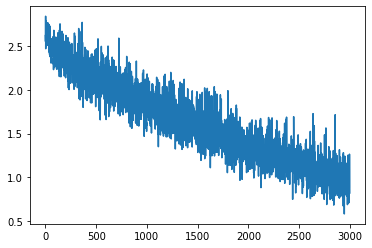

In [17]:
import matplotlib.pyplot as plt

plt.plot(range(len(l)), l)

# RAVDESS ONLY

In [51]:
len(train_dataset)

960

**train**

Epoch 0/99
----------
0,    50, loss: 2.539
0,    50, acc: 13.625

Epoch 1/99
----------
1,    50, loss: 2.422
1,    50, acc: 17.125

Epoch 2/99
----------
2,    50, loss: 2.347
2,    50, acc: 20.375

Epoch 3/99
----------
3,    50, loss: 2.190
3,    50, acc: 27.000

Epoch 4/99
----------
4,    50, loss: 2.098
4,    50, acc: 31.375

Epoch 5/99
----------
5,    50, loss: 1.948
5,    50, acc: 34.000

Epoch 6/99
----------
6,    50, loss: 1.884
6,    50, acc: 38.000

Epoch 7/99
----------
7,    50, loss: 1.793
7,    50, acc: 41.125

Epoch 8/99
----------
8,    50, loss: 1.676
8,    50, acc: 43.125

Epoch 9/99
----------
9,    50, loss: 1.653
9,    50, acc: 44.000

Epoch 10/99
----------
10,    50, loss: 1.572
10,    50, acc: 45.000

Epoch 11/99
----------
11,    50, loss: 1.475
11,    50, acc: 48.750

Epoch 12/99
----------
12,    50, loss: 1.449
12,    50, acc: 49.250

Epoch 13/99
----------
13,    50, loss: 1.351
13,    50, acc: 56.500

Epoch 14/99
----------
14,    50, loss: 1.336
14, 

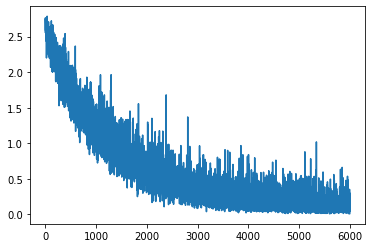

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
l = []

def train_model(model, criterion, num_epochs=100):
    
    net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.99))

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_correct = 0
        print("Epoch {}/{}".format(epoch, num_epochs-1))
        print("-" * 10)

        for i, (x, target) in enumerate(train_loader):
    
          if torch.cuda.is_available():
            x = x.cuda()
            target = target.cuda()

            optimizer.zero_grad()
            output = model(x.float())
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            preds = output.argmax(dim=1)
            running_correct += (preds == target).sum()

            l.append(loss.item())

            if (i+1) % 50 == 0:
                #print(preds, "!!", target)
                print("%d, %5d, loss: %.3f" % (epoch, i+1, running_loss/50))
                print("%d, %5d, acc: %.3f" % (epoch, i+1, 100.0 * running_correct/(16.0*50.0)))
                running_loss = 0.0
                running_correct = 0
                print()
        



net = Emo2DNet(14)
if torch.cuda.is_available():
  net = net.cuda()

train_model(model=net, criterion=nn.CrossEntropyLoss())

import matplotlib.pyplot as plt

plt.plot(range(len(l)), l)

In [23]:
print(max(l))
print(min(l))

2.7873589992523193
0.004616294521838427


**validate**

Epoch 0/29
----------
0,    15, loss: 1.468
0,    15, acc: 69.583

Epoch 1/29
----------
1,    15, loss: 1.476
1,    15, acc: 62.083

Epoch 2/29
----------
2,    15, loss: 1.472
2,    15, acc: 60.833

Epoch 3/29
----------
3,    15, loss: 1.516
3,    15, acc: 60.000

Epoch 4/29
----------
4,    15, loss: 1.487
4,    15, acc: 63.750

Epoch 5/29
----------
5,    15, loss: 1.600
5,    15, acc: 60.417

Epoch 6/29
----------
6,    15, loss: 1.497
6,    15, acc: 62.500

Epoch 7/29
----------
7,    15, loss: 1.432
7,    15, acc: 62.083

Epoch 8/29
----------
8,    15, loss: 1.422
8,    15, acc: 67.083

Epoch 9/29
----------
9,    15, loss: 1.418
9,    15, acc: 66.250

Epoch 10/29
----------
10,    15, loss: 1.516
10,    15, acc: 62.083

Epoch 11/29
----------
11,    15, loss: 1.415
11,    15, acc: 66.667

Epoch 12/29
----------
12,    15, loss: 1.474
12,    15, acc: 62.917

Epoch 13/29
----------
13,    15, loss: 1.422
13,    15, acc: 60.833

Epoch 14/29
----------
14,    15, loss: 1.558
14, 

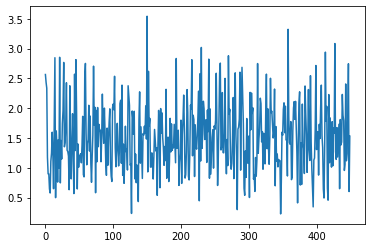

In [41]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
eval_l = []

def eval_model(model, criterion, num_epochs=30):

    acc = 0.0
    ll = 0.0

    best_model_wts = model.state_dict()    
    #net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.99))
    
    model.eval()
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_correct = 0
        print("Epoch {}/{}".format(epoch, num_epochs-1))
        print("-" * 10)

        for i, (x, target) in enumerate(valid_loader):
    
          if torch.cuda.is_available():
            x = x.cuda()
            target = target.cuda()

          output = model(x.float())
          loss = criterion(output, target)
          
          running_loss += loss.item()

          preds = output.argmax(dim=1)
          running_correct += (preds == target).sum()

          eval_l.append(loss.item())

          if (i+1) == 15:
            #print(running_correct)
            r_l = running_loss/15
            r_a = 100.0 * running_correct/(16.0*15.0)
            print("%d, %5d, loss: %.3f" % (epoch, i+1, r_l))
            print("%d, %5d, acc: %.3f" % (epoch, i+1, r_a))
            running_loss = 0.0
            running_correct = 0
            if r_a > acc:
              acc = r_a 
              ll = loss.item()
              best_model_wts = model.state_dict()
            #print(confusion_matrix(preds.cpu(), target.cpu()))
            print()

    return best_model_wts, acc, ll
        

val_net, acc, ll = eval_model(model=net, criterion=nn.CrossEntropyLoss())

import matplotlib.pyplot as plt

plt.plot(range(len(eval_l)), eval_l)
print(max(eval_l))
print(min(eval_l))

print("best")
print(acc, ll)

**test**

In [61]:
with open('RAV_val_net.pkl', 'wb') as f:
  pickle.dump(eval_net, f)

In [50]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
correct = 0

test_net = Emo2DNet(14)
test_net.load_state_dict(eval_net)

for i, (x, target) in enumerate(test_loader):
  if torch.cuda.is_available():
    x = x.cuda()
    target = target.cuda()
    test_net = test_net.cuda()

  output = test_net(x.float())
  preds = output.argmax(dim=1)

  correct += (preds == target).sum()
  print(confusion_matrix(preds.cpu(), target.cpu()))

acc = 100. * correct / len(test_loader.dataset)

print("ACC Test")
print(acc)

[[1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 1 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 3 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0 1 0 1 0 0 0 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2]
 [0 0 0 0 0 0 0 0 0 0 0 4 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0]]
[[3 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 3 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 3 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1 4 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 3 0 0 0]]
[[2 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 4 2 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2]
 [0 0 0 0 0 0 1 0 0 0 0 0

# Other Dataset


In [52]:
import pickle
import pandas as pd

with open("/gdrive/My Drive/mel_crema.pkl", 'rb') as f:
    mel_c = pickle.load(f)

with open("/gdrive/My Drive/mel_3.pkl", 'rb') as f:
    mel_3 = pickle.load(f)

print(mel_c.shape)
print(mel_3.shape)

ref = pd.read_csv("/gdrive/My Drive/Data_path.csv")
ref = ref.drop(11586)

(7062, 30, 216, 1)
(4524, 30, 216, 1)


In [53]:
mel = np.concatenate((mel_3, mel_c), axis=0)
mel.shape

(11586, 30, 216, 1)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(mel, ref.labels, test_size=0.2, shuffle=True, random_state=42)


# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

# Normalization as per the standard NN process
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [55]:
train_dataset = myDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size= 12, shuffle=True)

valid_dataset = myDataset(X_test, y_test)
valid_loader = DataLoader(valid_dataset, batch_size= 64, shuffle=True)

In [56]:
class Emo2DNet_2(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.n = n
        self.conv1 = nn.Conv2d(1, 32, kernel_size = (3, 9), padding=(1,4))
        self.b_norm1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 32, kernel_size = (3, 9), padding=(1,4))
        self.b_norm2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 32, kernel_size = (3, 9), padding=(1,4))
        self.b_norm3 = nn.BatchNorm2d(32)
        
        self.conv4 = nn.Conv2d(32, 32, kernel_size = (3, 9), padding=(1,4))
        self.b_norm4 = nn.BatchNorm2d(32)
        
        self.b_norm5 = nn.BatchNorm1d(64) #
        
        self.fc1 = nn.Linear(32*13, 64)
        self.fc2 = nn.Linear(64, 14)
        #self.fc3 = nn.Linear(32, 14)
        
    def forward(self, x):

        x = self.conv1(x)
        x = nn.ReLU()(self.b_norm1(x))
        x = nn.MaxPool2d(2)(x)
        x = nn.Dropout2d(p=0.2)(x)

        x = self.conv2(x)
        x = nn.ReLU()(self.b_norm2(x))
        x = nn.MaxPool2d(2)(x)
        x = nn.Dropout2d(p=0.2)(x)

        x = self.conv3(x)
        x = nn.ReLU()(self.b_norm3(x))
        x = nn.MaxPool2d(2)(x)
        x = nn.Dropout2d(p=0.2)(x)
        
        x = self.conv4(x)
        x = nn.ReLU()(self.b_norm4(x))
        x = nn.MaxPool2d(2)(x)
        x = nn.Dropout2d(p=0.2)(x)

        x = x.view(-1, 32*13)
        x = self.fc1(x)
        x = nn.Dropout(p=0.2)(x)
        
        x = self.b_norm5(x)

        x = nn.ReLU()(x)
        x = nn.Dropout(p=0.2)(x)
        x = self.fc2(x)

        return x

In [57]:
len(train_dataset)

9268

**train**

In [66]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_l = []


def train_model_2(model, criterion, num_epochs=100):
    
    #net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.99))
    
    #model.eval()
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_correct = 0
        print("Epoch {}/{}".format(epoch, num_epochs-1))
        print("-" * 10)

        for i, (x, target) in enumerate(train_loader):
    
          if torch.cuda.is_available():
            x = x.cuda()
            target = target.cuda()

            optimizer.zero_grad()
            output = model(x.float())
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            train_l.append(loss.item())

            preds = output.argmax(dim=1)
            running_correct += (preds == target).sum()

            if (i+1) % 700 == 0:
                #print(running_correct)
                print("%d, %5d, loss: %.3f" % (epoch+1, i+1, running_loss/700 ))
                print("%d, %5d, acc: %.3f" % (epoch+1, i+1, 100.0 * running_correct/(12*700)))
                running_loss = 0.0
                running_correct = 0
                #test_l.append(loss.item())
                #print(confusion_matrix(preds.cpu(), target.cpu()))
                print()

mel_model = Emo2DNet_2(14)
if torch.cuda.is_available():
  mel_model = mel_model.cuda()

train_model(model=mel_model, criterion=nn.CrossEntropyLoss())

Epoch 0/99
----------
1,   700, loss: 2.518
1,   700, acc: 13.714

Epoch 1/99
----------
2,   700, loss: 2.350
2,   700, acc: 20.548

Epoch 2/99
----------
3,   700, loss: 2.248
3,   700, acc: 23.429

Epoch 3/99
----------
4,   700, loss: 2.170
4,   700, acc: 26.429

Epoch 4/99
----------
5,   700, loss: 2.073
5,   700, acc: 29.452

Epoch 5/99
----------
6,   700, loss: 1.983
6,   700, acc: 31.595

Epoch 6/99
----------
7,   700, loss: 1.906
7,   700, acc: 34.452

Epoch 7/99
----------
8,   700, loss: 1.855
8,   700, acc: 35.679

Epoch 8/99
----------
9,   700, loss: 1.798
9,   700, acc: 36.881

Epoch 9/99
----------
10,   700, loss: 1.775
10,   700, acc: 37.905

Epoch 10/99
----------
11,   700, loss: 1.727
11,   700, acc: 38.881

Epoch 11/99
----------
12,   700, loss: 1.692
12,   700, acc: 40.429

Epoch 12/99
----------
13,   700, loss: 1.663
13,   700, acc: 41.321

Epoch 13/99
----------
14,   700, loss: 1.645
14,   700, acc: 41.500

Epoch 14/99
----------
15,   700, loss: 1.597
15

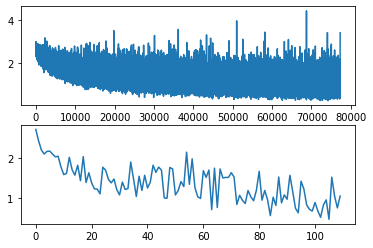

In [77]:
plt.subplot(2, 1,1)
plt.plot(range(len(train_l)), train_l)
e = []
for i in range(len(train_l)//700):
  e.append(train_l[i*700])
plt.subplot(2, 1, 2)
plt.plot(range(len(e)), e)

In [76]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
val_l = []
ep_val_l = []

def eval_model_2(model, criterion, num_epochs=100):
    acc = 0.0
    ll = 0.0

    #net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.99))
    
    model.eval()
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_correct = 0
        print("Epoch {}/{}".format(epoch, num_epochs-1))
        print("-" * 10)

        for i, (x, target) in enumerate(train_loader):
    
          if torch.cuda.is_available():
            x = x.cuda()
            target = target.cuda()

            #optimizer.zero_grad()
          output = model(x.float())
          loss = criterion(output, target)
          running_loss += loss.item()

          val_l.append(loss.item())

          preds = output.argmax(dim=1)
          running_correct += (preds == target).sum()
          
          if (i+1) == 15:
            #print(running_correct)
            r_l = running_loss/15
            r_a = 100.0 * running_correct/(64.0*15.0)
            print("%d, %5d, loss: %.3f" % (epoch, i+1, r_l))
            print("%d, %5d, acc: %.3f" % (epoch, i+1, r_a))
            running_loss = 0.0
            running_correct = 0
          
            if r_a > acc:
              acc = r_a 
              ll = loss.item()
              best_model_wts = model.state_dict()
            #print(confusion_matrix(preds.cpu(), target.cpu()))
            print()

    return best_model_wts, acc, ll

val_mel_model, acc, ll = eval_model_2(model=mel_model, criterion=nn.CrossEntropyLoss())
print("best acc: ", acc, "  loss: ", ll)

with open('Data_val_mel_model.pkl', 'wb') as f:
  pickle.dump(val_mel_model, f)

Epoch 0/99
----------
0,    15, loss: 0.890
0,    15, acc: 52.500

Epoch 1/99
----------
1,    15, loss: 0.823
1,    15, acc: 54.583

Epoch 2/99
----------
2,    15, loss: 0.774
2,    15, acc: 57.500

Epoch 3/99
----------
3,    15, loss: 0.813
3,    15, acc: 52.917

Epoch 4/99
----------
4,    15, loss: 0.913
4,    15, acc: 52.917

Epoch 5/99
----------
5,    15, loss: 0.978
5,    15, acc: 50.833

Epoch 6/99
----------
6,    15, loss: 0.872
6,    15, acc: 52.917

Epoch 7/99
----------
7,    15, loss: 0.774
7,    15, acc: 55.000

Epoch 8/99
----------
8,    15, loss: 0.959
8,    15, acc: 50.833

Epoch 9/99
----------
9,    15, loss: 0.787
9,    15, acc: 59.167

Epoch 10/99
----------
10,    15, loss: 0.730
10,    15, acc: 57.083

Epoch 11/99
----------
11,    15, loss: 0.782
11,    15, acc: 55.000

Epoch 12/99
----------
12,    15, loss: 0.892
12,    15, acc: 51.250

Epoch 13/99
----------
13,    15, loss: 0.802
13,    15, acc: 52.917

Epoch 14/99
----------
14,    15, loss: 0.764
14, 

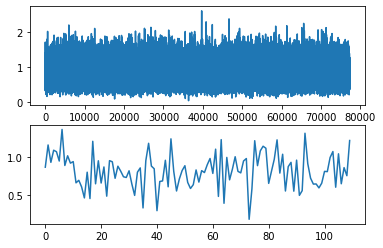

In [78]:
plt.subplot(2, 1,1)
plt.plot(range(len(val_l)), val_l)
e = []
for i in range(len(val_l)//700):
  e.append(val_l[i*700])
plt.subplot(2, 1, 2)
plt.plot(range(len(e)), e)

#MFCC

In [79]:
import pickle
import pandas as pd

with open("/gdrive/My Drive/mfcc_crema.pkl", 'rb') as f:
    ref_c = pickle.load(f)

with open("/gdrive/My Drive/mfcc_3.pkl", 'rb') as f:
    ref_3 = pickle.load(f)

print(ref_c.shape)
print(ref_3.shape)

ref = pd.read_csv("/gdrive/My Drive/Data_path.csv")
ref = ref.drop(11586)

(7062, 30, 216, 1)
(4524, 30, 216, 1)


In [84]:
mfcc = np.concatenate((ref_3, ref_c), axis=0)
mfcc.shape

(11586, 30, 216, 1)

In [85]:
X_train, X_test, y_train, y_test = train_test_split(mfcc, ref.labels, test_size=0.2, shuffle=True, random_state=42)


# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

# Normalization as per the standard NN process
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [86]:
train_dataset = myDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size= 12, shuffle=True)

valid_dataset = myDataset(X_test, y_test)
valid_loader = DataLoader(valid_dataset, batch_size= 64, shuffle=True)

In [87]:
len(train_dataset)

9268

**train**

Epoch 0/99
----------
1,   700, loss: 2.555
1,   700, acc: 12.631

Epoch 1/99
----------
2,   700, loss: 2.295
2,   700, acc: 21.024

Epoch 2/99
----------
3,   700, loss: 2.155
3,   700, acc: 26.607

Epoch 3/99
----------
4,   700, loss: 2.033
4,   700, acc: 31.405

Epoch 4/99
----------
5,   700, loss: 1.909
5,   700, acc: 35.964

Epoch 5/99
----------
6,   700, loss: 1.814
6,   700, acc: 38.536

Epoch 6/99
----------
7,   700, loss: 1.751
7,   700, acc: 40.845

Epoch 7/99
----------
8,   700, loss: 1.678
8,   700, acc: 42.631

Epoch 8/99
----------
9,   700, loss: 1.631
9,   700, acc: 44.512

Epoch 9/99
----------
10,   700, loss: 1.604
10,   700, acc: 44.464

Epoch 10/99
----------
11,   700, loss: 1.566
11,   700, acc: 46.667

Epoch 11/99
----------
12,   700, loss: 1.526
12,   700, acc: 47.095

Epoch 12/99
----------
13,   700, loss: 1.510
13,   700, acc: 47.036

Epoch 13/99
----------
14,   700, loss: 1.469
14,   700, acc: 49.524

Epoch 14/99
----------
15,   700, loss: 1.457
15

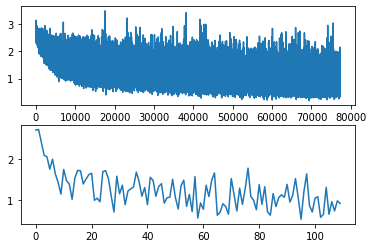

In [88]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_l_m = []


def train_model_2(model, criterion, num_epochs=100):
    
    #net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.99))
    
    #model.eval()
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_correct = 0
        print("Epoch {}/{}".format(epoch, num_epochs-1))
        print("-" * 10)

        for i, (x, target) in enumerate(train_loader):
    
          if torch.cuda.is_available():
            x = x.cuda()
            target = target.cuda()

            optimizer.zero_grad()
            output = model(x.float())
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            train_l_m.append(loss.item())

            preds = output.argmax(dim=1)
            running_correct += (preds == target).sum()

            if (i+1) % 700 == 0:
                #print(running_correct)
                print("%d, %5d, loss: %.3f" % (epoch+1, i+1, running_loss/700 ))
                print("%d, %5d, acc: %.3f" % (epoch+1, i+1, 100.0 * running_correct/(12*700)))
                running_loss = 0.0
                running_correct = 0
                #test_l.append(loss.item())
                #print(confusion_matrix(preds.cpu(), target.cpu()))
                print()

mfcc_model = Emo2DNet_2(14)
if torch.cuda.is_available():
  mfcc_model = mfcc_model.cuda()

train_model_2(model=mfcc_model, criterion=nn.CrossEntropyLoss())

plt.subplot(2, 1,1)
plt.plot(range(len(train_l_m)), train_l_m)
e = []
for i in range(len(train_l_m)//700):
  e.append(train_l_m[i*700])
plt.subplot(2, 1, 2)
plt.plot(range(len(e)), e)

Epoch 0/99
----------
0,    15, loss: 1.291
0,    15, acc: 56.667

Epoch 1/99
----------
1,    15, loss: 1.272
1,    15, acc: 56.667

Epoch 2/99
----------
2,    15, loss: 1.242
2,    15, acc: 56.458

Epoch 3/99
----------
3,    15, loss: 1.361
3,    15, acc: 54.896

Epoch 4/99
----------
4,    15, loss: 1.335
4,    15, acc: 56.875

Epoch 5/99
----------
5,    15, loss: 1.310
5,    15, acc: 55.104

Epoch 6/99
----------
6,    15, loss: 1.313
6,    15, acc: 57.083

Epoch 7/99
----------
7,    15, loss: 1.294
7,    15, acc: 56.875

Epoch 8/99
----------
8,    15, loss: 1.252
8,    15, acc: 57.813

Epoch 9/99
----------
9,    15, loss: 1.284
9,    15, acc: 56.458

Epoch 10/99
----------
10,    15, loss: 1.270
10,    15, acc: 55.729

Epoch 11/99
----------
11,    15, loss: 1.300
11,    15, acc: 54.688

Epoch 12/99
----------
12,    15, loss: 1.317
12,    15, acc: 55.104

Epoch 13/99
----------
13,    15, loss: 1.259
13,    15, acc: 57.917

Epoch 14/99
----------
14,    15, loss: 1.230
14, 

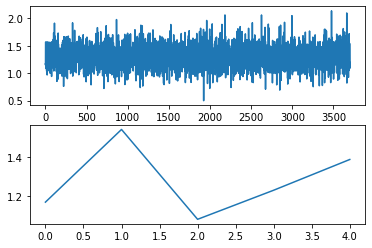

In [90]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
val_l = []
ep_val_l = []

def eval_model_2(model, criterion, num_epochs=100):
    acc = 0.0
    ll = 0.0

    #net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.99))
    
    model.eval()
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_correct = 0
        print("Epoch {}/{}".format(epoch, num_epochs-1))
        print("-" * 10)

        for i, (x, target) in enumerate(valid_loader):
    
          if torch.cuda.is_available():
            x = x.cuda()
            target = target.cuda()

            #optimizer.zero_grad()
          output = model(x.float())
          loss = criterion(output, target)
          running_loss += loss.item()

          val_l.append(loss.item())

          preds = output.argmax(dim=1)
          running_correct += (preds == target).sum()
          
          if (i+1) == 15:
            #print(running_correct)
            r_l = running_loss/15
            r_a = 100.0 * running_correct/(64.0*15.0)
            print("%d, %5d, loss: %.3f" % (epoch, i+1, r_l))
            print("%d, %5d, acc: %.3f" % (epoch, i+1, r_a))
            running_loss = 0.0
            running_correct = 0
          
            if r_a > acc:
              acc = r_a 
              ll = loss.item()
              best_model_wts = model.state_dict()
            #print(confusion_matrix(preds.cpu(), target.cpu()))
            print()

    return best_model_wts, acc, ll

val_mfcc_model, acc, ll = eval_model_2(model=mfcc_model, criterion=nn.CrossEntropyLoss())
print("best acc: ", acc, "  loss: ", ll)

with open('Data_val_mfcc_model.pkl', 'wb') as f:
  pickle.dump(val_mfcc_model, f)


plt.subplot(2, 1,1)
plt.plot(range(len(val_l)), val_l)


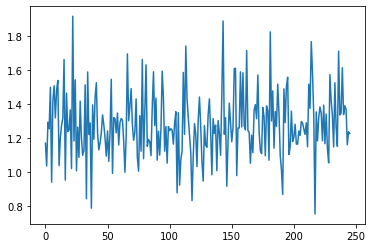

In [91]:
e = []
for i in range(len(val_l)//15):
  e.append(val_l[i*15])
plt.plot(range(len(e)), e)

**To Delete**

In [44]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_l = []
train_l = []
conf_mat_ypred = np.zeros((14))
conf_mat_target = np.zeros((14))

# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()

def fit(model, num_epochs=100):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.99))
    #scheduler = lr_scheduler.StepLR(optimizer, step_size=60, gamma=0.1)
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs-1))
        print("-" * 10)

        for phase in ['train', 'valid']:
          if phase == 'valid':
            model.eval()
          elif phase == 'train':
            model.train()
            
          running_loss = 0.0
          running_correct = 0

          if phase == 'train':
            for i, (x, target) in enumerate(train_loader):
    
              if torch.cuda.is_available():
                x = x.cuda()
                target = target.cuda()

                optimizer.zero_grad()
                output = model(x.float())
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                preds = output.argmax(dim=1)
                running_correct += (preds == target).sum()

                if (i+1) % 700 == 0:
                #print(running_correct)
                  print("%d, %5d, loss: %.3f" % (epoch+1, i+1, running_loss/700 ))
                  print("%d, %5d, acc: %.3f" % (epoch+1, i+1, 100.0 * running_correct/(12*700)))
                  running_loss = 0.0
                  running_correct = 0
                  train_l.append(loss.item())
                  #print(confusion_matrix(preds.cpu(), target.cpu()))
                  print()

              #scheduler.step()
            
          if phase == 'valid':
            for i, (x, target) in enumerate(valid_loader):
              if torch.cuda.is_available():
                x = x.cuda()
                target = target.cuda()

                output = model(x.float())
                loss = criterion(output, target)

                running_loss += loss.item()

                preds = output.argmax(dim=1)
                running_correct += (preds == target).sum()

                if (i+1) % 100 == 0:
                #print(running_correct)
                  print("%s, %d, %5d, loss: %.3f" % (phase, epoch+1, i+1, running_loss/100 ))
                  print("%d, %5d, acc: %.3f" % (epoch+1, i+1, 100.0 * running_correct/(12*100)))
                  running_loss = 0.0
                  running_correct = 0
                  test_l.append(loss.item())
                  #print(confusion_matrix(preds.cpu(), target.cpu()))
                  print()

mfcc_model = Emo2DNet_2(14)
if torch.cuda.is_available():
  mfcc_model = mfcc_model.cuda()

fit(model=mfcc_model)

plt.plot(range(len(train_l)), test_l)
plt.plot(range(len(test_l)), test_l)

Epoch 0/99
----------
1,   700, loss: 2.535
1,   700, acc: 13.917

Epoch 1/99
----------
2,   700, loss: 2.342
2,   700, acc: 19.988

Epoch 2/99
----------
3,   700, loss: 2.227
3,   700, acc: 24.393

Epoch 3/99
----------
4,   700, loss: 2.131
4,   700, acc: 27.393

Epoch 4/99
----------
5,   700, loss: 2.035
5,   700, acc: 31.071

Epoch 5/99
----------
6,   700, loss: 1.942
6,   700, acc: 33.429

Epoch 6/99
----------
7,   700, loss: 1.885
7,   700, acc: 35.369

Epoch 7/99
----------
8,   700, loss: 1.825
8,   700, acc: 36.357

Epoch 8/99
----------
9,   700, loss: 1.790
9,   700, acc: 37.083

Epoch 9/99
----------
10,   700, loss: 1.739
10,   700, acc: 38.690

Epoch 10/99
----------
11,   700, loss: 1.727
11,   700, acc: 38.821

Epoch 11/99
----------
12,   700, loss: 1.687
12,   700, acc: 40.821

Epoch 12/99
----------
13,   700, loss: 1.661
13,   700, acc: 41.595

Epoch 13/99
----------
14,   700, loss: 1.628
14,   700, acc: 42.798

Epoch 14/99
----------
15,   700, loss: 1.615
15

In [63]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
l = []

def train_model_2(model, criterion, num_epochs=100):
    
    net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.00001, betas=(0.9, 0.99))

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_correct = 0
        print("Epoch {}/{}".format(epoch, num_epochs-1))
        print("-" * 10)

        for i, (x, target) in enumerate(train_loader):
    
          if torch.cuda.is_available():
            x = x.cuda()
            target = target.cuda()

            optimizer.zero_grad()
            output = model(x.float())
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            preds = output.argmax(dim=1)
            running_correct += (preds == target).sum()

            l.append(loss.item())

            if (i+1) % 700 == 0:
                #print(preds, "!!", target)
                print("%d, %5d, loss: %.3f" % (epoch, i+1, running_loss/700))
                print("%d, %5d, acc: %.3f" % (epoch, i+1, 100.0 * running_correct/(12.0*700.0)))
                running_loss = 0.0
                running_correct = 0
                print()
        



net_2 = Emo2DNet_2(14)
if torch.cuda.is_available():
  net_2 = net_2.cuda()

train_model_2(model=net_2, criterion=nn.CrossEntropyLoss())

import matplotlib.pyplot as plt

plt.plot(range(len(l)), l)

Epoch 0/99
----------
0,   700, loss: 2.751
0,   700, acc: 6.774

Epoch 1/99
----------
1,   700, loss: 2.742
1,   700, acc: 7.476

Epoch 2/99
----------
2,   700, loss: 2.740
2,   700, acc: 7.536

Epoch 3/99
----------
3,   700, loss: 2.755
3,   700, acc: 6.762

Epoch 4/99
----------
4,   700, loss: 2.754
4,   700, acc: 6.893

Epoch 5/99
----------
5,   700, loss: 2.742
5,   700, acc: 7.036

Epoch 6/99
----------
6,   700, loss: 2.748
6,   700, acc: 7.024

Epoch 7/99
----------
7,   700, loss: 2.743
7,   700, acc: 7.643

Epoch 8/99
----------
8,   700, loss: 2.745
8,   700, acc: 7.000

Epoch 9/99
----------
9,   700, loss: 2.751
9,   700, acc: 7.060

Epoch 10/99
----------
10,   700, loss: 2.749
10,   700, acc: 6.738

Epoch 11/99
----------
11,   700, loss: 2.740
11,   700, acc: 7.690

Epoch 12/99
----------
12,   700, loss: 2.748
12,   700, acc: 6.750

Epoch 13/99
----------
13,   700, loss: 2.748
13,   700, acc: 7.250

Epoch 14/99
----------
14,   700, loss: 2.745
14,   700, acc: 7.

KeyboardInterrupt: ignored

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_l = []

# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()

def train_model(model, criterion, num_epochs=100):
    
    #net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.99))
    lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=60, gamma=0.1)
    
    #model.eval()
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_correct = 0
        print("Epoch {}/{}".format(epoch, num_epochs-1))
        print("-" * 10)

        for i, (x, target) in enumerate(train_loader):
    
          if torch.cuda.is_available():
            x = x.cuda()
            target = target.cuda()

            optimizer.zero_grad()
            output = model(x.float())
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            train_l.append(loss.item())

            preds = output.argmax(dim=1)
            running_correct += (preds == target).sum()

            if (i+1) % 700 == 0:
                #print(running_correct)
                print("%d, %5d, loss: %.3f" % (epoch+1, i+1, running_loss/700 ))
                print("%d, %5d, acc: %.3f" % (epoch+1, i+1, 100.0 * running_correct/(12*700)))
                running_loss = 0.0
                running_correct = 0
                #test_l.append(loss.item())
                #print(confusion_matrix(preds.cpu(), target.cpu()))
                print()

mel_model = Emo2DNet_2(14)
if torch.cuda.is_available():
  mel_model = mel_model.cuda()

train_model(model=mel_model, criterion=nn.CrossEntropyLoss())

Epoch 0/99
----------
1,   700, loss: 2.518
1,   700, acc: 14.631

Epoch 1/99
----------
2,   700, loss: 2.339
2,   700, acc: 20.179

Epoch 2/99
----------
3,   700, loss: 2.233
3,   700, acc: 23.917

Epoch 3/99
----------
4,   700, loss: 2.134
4,   700, acc: 26.762

Epoch 4/99
----------
5,   700, loss: 2.031
5,   700, acc: 30.667

Epoch 5/99
----------
6,   700, loss: 1.949
6,   700, acc: 32.702

Epoch 6/99
----------
7,   700, loss: 1.879
7,   700, acc: 34.750

Epoch 7/99
----------
8,   700, loss: 1.822
8,   700, acc: 36.607

Epoch 8/99
----------
9,   700, loss: 1.792
9,   700, acc: 37.786

Epoch 9/99
----------
10,   700, loss: 1.757
10,   700, acc: 37.690

Epoch 10/99
----------
11,   700, loss: 1.711
11,   700, acc: 40.690

Epoch 11/99
----------
12,   700, loss: 1.684
12,   700, acc: 41.024

Epoch 12/99
----------
13,   700, loss: 1.651
13,   700, acc: 41.798

Epoch 13/99
----------
14,   700, loss: 1.622
14,   700, acc: 43.405

Epoch 14/99
----------
15,   700, loss: 1.592
15

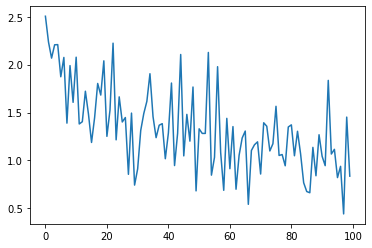

In [32]:
plt.plot(range(len(test_l)), test_l)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
val_l = []
ep_val_l = []

def eval_model_2(model, criterion, num_epochs=100):
    
    #net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.99))
    
    model.eval()
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_correct = 0
        print("Epoch {}/{}".format(epoch, num_epochs-1))
        print("-" * 10)

        for i, (x, target) in enumerate(train_loader):
    
          if torch.cuda.is_available():
            x = x.cuda()
            target = target.cuda()

            #optimizer.zero_grad()
          output = model(x.float())
          loss = criterion(output, target)
          running_loss += loss.item()

          val_l.append(loss.item())

          preds = output.argmax(dim=1)
          running_correct += (preds == target).sum()

          if (i+1) % 700 == 0:
            #print(running_correct)
            print("%d, %5d, loss: %.3f" % (epoch+1, i+1, running_loss/700 ))
            print("%d, %5d, acc: %.3f" % (epoch+1, i+1, 100.0 * running_correct/(12*700)))
            running_loss = 0.0
            running_correct = 0
            ep_val_l.append(loss.item())
            #print(confusion_matrix(preds.cpu(), target.cpu()))
            print()

e_model(model=mel_model, criterion=nn.CrossEntropyLoss())

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_l = []
train_l = []
conf_mat_ypred = np.zeros((14))
conf_mat_target = np.zeros((14))

# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()

def fit(model, num_epochs=100):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.99))
    #scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs-1))
        print("-" * 10)

        for phase in ['train', 'valid']:
          
          if phase == 'valid':
            model.eval()
          elif phase == 'train':
            model.train()
            
          running_loss = 0.0
          running_correct = 0

          if phase == 'train':
            for i, (x, target) in enumerate(train_loader):
    
              if torch.cuda.is_available():
                x = x.cuda()
                target = target.cuda()

                optimizer.zero_grad()
                output = model(x.float())
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                preds = output.argmax(dim=1)
                running_correct += (preds == target).sum()

                if (i+1) % 700 == 0:
                #print(running_correct)
                    print("%s %d, %5d, loss: %.3f" % (phase, epoch+1, i+1, running_loss/700 ))
                    print("%d, %5d, acc: %.3f" % (epoch+1, i+1, 100.0 * running_correct/(12*700)))
                    running_loss = 0.0
                    running_correct = 0
                    train_l.append(loss.item())
                    #print(confusion_matrix(preds.cpu(), target.cpu()))
                    print()
            
          if phase == 'valid':
            for i, (x, target) in enumerate(valid_loader):
              if torch.cuda.is_available():
                x = x.cuda()
                target = target.cuda()

                output = model(x.float())
                loss = criterion(output, target)

                running_loss += loss.item()

                preds = output.argmax(dim=1)
                running_correct += (preds == target).sum()

                if (i+1) % 100 == 0:
                #print(running_correct)
                    print("%s %d, %5d, loss: %.3f" % (phase, epoch+1, i+1, running_loss/100 ))
                    print("%d, %5d, acc: %.3f" % (epoch+1, i+1, 100.0 * running_correct/(12*100)))
                    running_loss = 0.0
                    running_correct = 0
                    test_l.append(loss.item())
                    #print(confusion_matrix(preds.cpu(), target.cpu()))
                    print()

          #scheduler.step()
          #if epoch % 30 == 0:
          #  print(epoch, " lr : ", optimizer.param_groups[0]['lr'])

mel_model = Emo2DNet_2(14)
if torch.cuda.is_available():
  mel_model = mel_model.cuda()

fit(model=mel_model)

Epoch 0/99
----------
train 1,   700, loss: 2.525
1,   700, acc: 13.321

0  lr :  0.0001
0  lr :  0.0001
Epoch 1/99
----------
train 2,   700, loss: 2.347
2,   700, acc: 19.071

Epoch 2/99
----------
train 3,   700, loss: 2.238
3,   700, acc: 23.560

Epoch 3/99
----------
train 4,   700, loss: 2.148
4,   700, acc: 26.929

Epoch 4/99
----------
train 5,   700, loss: 2.061
5,   700, acc: 30.202

Epoch 5/99
----------
train 6,   700, loss: 1.975
6,   700, acc: 32.500

Epoch 6/99
----------
train 7,   700, loss: 1.910
7,   700, acc: 33.988

Epoch 7/99
----------
train 8,   700, loss: 1.845
8,   700, acc: 36.833

Epoch 8/99
----------
train 9,   700, loss: 1.792
9,   700, acc: 37.905

Epoch 9/99
----------
train 10,   700, loss: 1.744
10,   700, acc: 39.512

Epoch 10/99
----------
train 11,   700, loss: 1.713
11,   700, acc: 40.655

Epoch 11/99
----------
train 12,   700, loss: 1.687
12,   700, acc: 41.048

Epoch 12/99
----------
train 13,   700, loss: 1.649
13,   700, acc: 42.512

Epoch 13